In [9]:
from aicsimageio import AICSImage
from aicsimageio.writers.ome_tiff_writer import OmeTiffWriter
from skimage import exposure
from plantseg.predictions.functional.predictions import unet_predictions
from plantseg.segmentation.functional.segmentation import *
import numpy as np
from tqdm import tqdm
from skimage.measure import regionprops, regionprops_table
from sklearn.model_selection import ParameterGrid
from skimage.segmentation import relabel_sequential
from cellpose import core, utils, io, models, metrics, plot
from cellpose.plot import *
from ome_types.model import OME, Image, Pixels, Channel
from scipy import stats
import matplotlib.pyplot as plt

## Image Loading

In [2]:
INPUT = "/media/Data3/Jacky/Data/myocardial_cells/20240109 segmentation Jacky/no17_NS_lv7_cTnI-594_CD31-750_PDGFRa-555_Ki67-647_WGA-488.czi"

OUTPUT_DIR = "/media/Data3/Jacky/Data/myocardial_cells/20240109 segmentation Jacky/no17_NS_lv7_cTnI-594_CD31-750_PDGFRa-555_Ki67-647_WGA-488_res"

In [19]:
SCENE_IDX=1
CH_IDX=1
SUBSAMPLE=10
TAIL=5

In [7]:
img = AICSImage(INPUT)
img.set_scene(SCENE_IDX)
img_dask = img.get_image_dask_data("CYX")
img_dask.persist()
img_dask_masked = img_dask[CH_IDX,:,:]

### Normalization

In [20]:
pl, pu = np.percentile(np.ravel(img_dask_masked[img_dask_masked >= 1200][::SUBSAMPLE,::SUBSAMPLE]), (TAIL, 100-TAIL))

if not isinstance(pl, (int,float)):
    pl = pl.compute()
if not isinstance(pu, (int,float)):
    pu = pu.compute()

print("Percentiles: ({:.2f},{:.2f})".format(pl,pu))

Percentiles: (3947.84,15592.94)


In [21]:
print("Rescaling image intensity...")
frame_rescaled = exposure.rescale_intensity(img_dask[CH_IDX,:,:], in_range=(pl, pu),out_range=(0,1))

Rescaling image intensity...


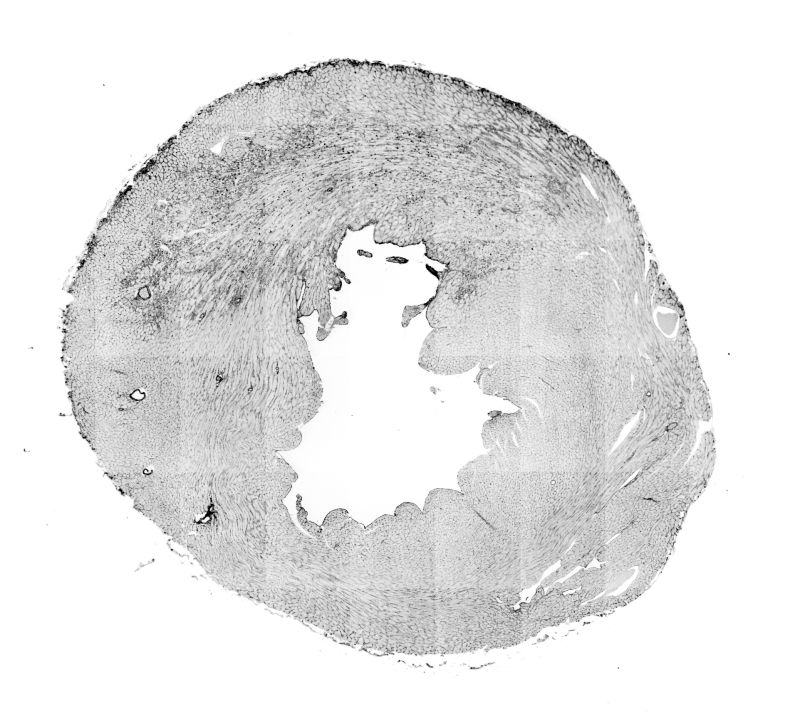

In [18]:
fig, axs = plt.subplots(1,1,figsize=(10,10))
axs.imshow(frame_rescaled[::SUBSAMPLE,::SUBSAMPLE],cmap="Greys")
axs.set_axis_off()

## Segmentation

In [32]:
pred = unet_predictions(frame_rescaled[np.newaxis,:,:],"lightsheet_2D_unet_root_ds1x",patch=[1,2048,2048])

2024-02-12 14:38:07,604 [MainThread] INFO PlantSeg - Using batch size of 1 for prediction


100%|██████████| 64/64 [00:29<00:00,  2.14it/s]


In [34]:
pred_masked = pred[0,:,:]
pred_masked[img_dask_masked < 1200] = 0

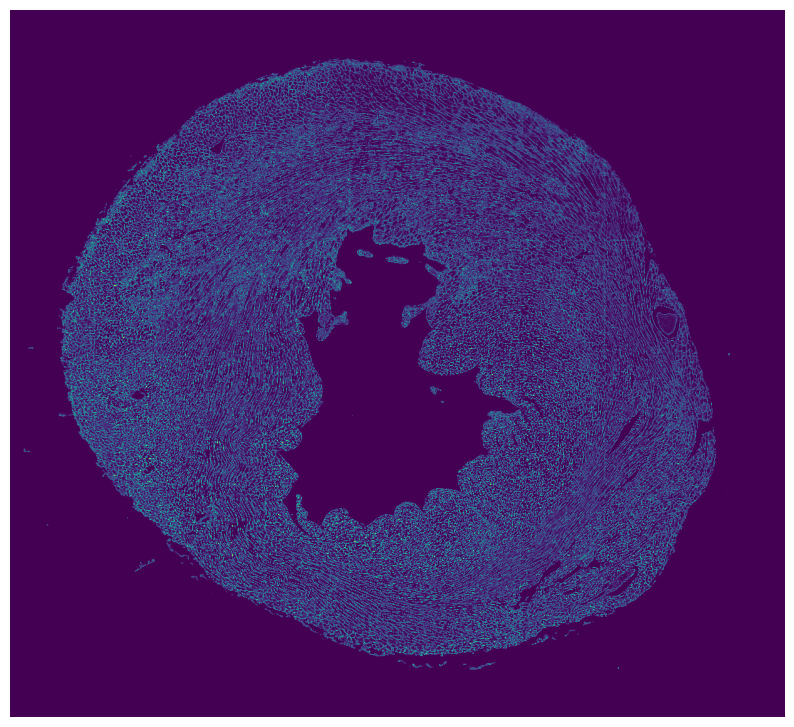

In [36]:
fig, axs = plt.subplots(1,1,figsize=(10,10))
axs.imshow(pred_masked[::SUBSAMPLE,::SUBSAMPLE],cmap="viridis")
axs.set_axis_off()